# TD Portfolio allocation : Covariance Cleaning

## Librairies

In [1]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.datasets import make_regression
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import time

## Efficient Frontier

In [2]:
def weights_optimal(mu_p, mu, cov_matrix ):
    
    # mean and correlation
    cov_matrix_inv = np.linalg.inv(cov_matrix)

    # forumulas
    one = np.ones(N).T
    A = one.T @ cov_matrix_inv @ one
    B = one.T @ cov_matrix_inv @ mu
    C = mu.T @ cov_matrix_inv @ mu
    D = A*C - B**2
    
    q = (C - (mu_p * B))/D
    p = ((mu_p * A) - B)/D

    # optimal weights
    w = (q * cov_matrix_inv @ one) + (p * cov_matrix_inv @ mu)
    
    return w

### Max Sharp Ratio

$ w_{MSR}= \frac{\Sigma^{-1}\mu}{\mathbb{1}^{T}\Sigma^{-1}\mu}$

In [3]:
def weights_MSR(mu,cov_matrix):
    one = np.ones(N).T
    cov_matrix_inv = np.linalg.inv(cov_matrix)  
    num = cov_matrix_inv @ mu
    den = one.T@num
    w_MSR=num/den
    return w_MSR

### Minimum Variance Portfolio

$ w_{GMV}= \frac{\Sigma^{-1}\mathbb{1}}{\mathbb{1}^{T}\Sigma^{-1}\mathbb{1}}$

In [4]:
def weights_GMV(cov_matrix):
    one=np.ones(N).T
    cov_matrix_inv = np.linalg.inv(cov_matrix)
    num=cov_matrix_inv@one
    den=one.T@num
    w_GMV=num/den   
    return w_GMV

### Risk Portfolio

$vol_{Portfolio}= \sqrt{252}*\sqrt{w \Sigma w^{T}}$

In [5]:
def risk_Portfolio(w,cov_matrix):
     
    vol_p =  np.sqrt(252) * np.sqrt(w @ cov_matrix @ w.T)

    return vol_p

## Eigenvalue clipping 

In [6]:
def lamda_max(N,T,sigma):
    return (sigma**2) * (1 + N/T + 2*np.sqrt(N/T))

In [7]:
def lambda_in (N,T,corr_matrix):
    
    """Clipping based on correlation matrix"""
    
    #sigma_clipping = 1
    eigenvalues,eigenvector = np.linalg.eig(corr_matrix)
    sigma_clipping = 1-max(eigenvalues)/N
    lamdamax = lamda_max(N, T, sigma_clipping)
    small_eigenvalues = np.array([elem for elem in eigenvalues if elem < lamdamax ])
    mean_small= np.mean(small_eigenvalues)
    diag_clipping = np.diag(np.diag([elem if elem > lamdamax else mean_small for elem in eigenvalues]))
    sorted_eigenvalues = np.sort(diag_clipping)[::-1]
    
    return sorted_eigenvalues

In [8]:
def corr_clipping (N,T,corr_matrix):
    
    """Clipping based on correlation matrix"""
    sigma_clipping = 1
    eigenvalues,eigenvector = np.linalg.eig(corr_matrix)
    #sigma = 1-max(eigenvalues)/N
    lamdamax = lamda_max(N, T, sigma_clipping)
    small_eigenvalues = np.array([elem for elem in eigenvalues if elem < lamdamax ])
    mean_small= np.mean(small_eigenvalues)
    diag_clipping = np.diag([elem if elem > lamdamax else mean_small for elem in eigenvalues])
    corr_clipping = eigenvector.T @ diag_clipping @ eigenvector
    
    return corr_clipping

In [9]:
def cov_clipping(N,T,corr_matrix,var_matrix):
    
    # calculation of the adjusted corrclipping coefficient
    corrclipping = corr_clipping(N,T, corr_matrix) 
    diag_corrclipping = np.diag(corrclipping)
    diag_corrclipping_inv = 1/diag_corrclipping
    corrclipping_adj = ((corrclipping @ np.eye(len(corrclipping))*diag_corrclipping_inv).T * diag_corrclipping_inv).T
    
    #var_matrix is the diagonal of the covariance matrix 
    covclipping = np.sqrt(var_matrix) @ corrclipping_adj @ np.sqrt(var_matrix)
    
    return covclipping
    
    

## Eigenvalue Cross Validation

In [10]:
#using cross validation


def lambdaCV(data, index_in_list,index_out_list):
    
    #return the lambda_CV for only one cross validation
    data_in = data.iloc[index_in_list]
    data_out = data.iloc[index_out_list]
    cov_matrix_in = np.cov(data_in.T, bias=True)
    cov_matrix_out = np.cov(data_out.T, bias=True)
    eigenvalues_in,eigenvectors_in = np.linalg.eig(cov_matrix_in)
    lambdaCV = eigenvectors_in.T @ cov_matrix_out @ eigenvectors_in
    
    return np.diag(lambdaCV)

def lambda_CV_moy(nbCV,data):
    
    #applied on the insample data for nbCV Cross validation:
    
    lambda_list = []
    size_in_CV = int(0.7*data.shape[0])
    listdata = range(data.shape[0])
    
    for i in range(nbCV):
        index_in_list = rd.sample(listdata,size_in_CV)
        index_out_list =[elem for elem in listdata if not elem in index_in_list]
        lambda_CV = lambdaCV(data, index_in_list, index_out_list)
        lambda_list.append(lambda_CV)
        
    lambda_list=np.array(lambda_list)
    data_CV=pd.DataFrame(lambda_list)
        
    return np.array(data_CV.mean(axis=0))


def lambda_CV_iso(nbCV,data):
    
    #Computation of lambda_in
    cov_matrix = np.cov(data.T, bias=True)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    
    #Retrieval of lambda_Cross validation
    lambdaCross = lambda_CV_moy(nbCV,data)
    iso_reg = IsotonicRegression().fit(eigenvalues,lambdaCross )
    lambda_iso=np.diag(iso_reg.predict(eigenvalues))
    
    return lambda_iso, eigenvalues, eigenvectors
    
def cov_matrix_CV(nbCV,data):
    lambda_iso, eigenvalues, eigenvectors = lambda_CV_iso(nbCV,data)
    cov_CV= eigenvectors @ lambda_iso @ eigenvectors.T
    return cov_CV



## Main Function

In [11]:
def efficient_frontier(data, method= "classic",nbCV=100):
    
    """method can take three values: classic, clipping or cv
    nbcv is used when the method is CV"""
    
    # Compute of the mean return and the covariance matrix of the assets
    mu = np.mean(data,axis = 0)
    
    # Estimator of the covariance matrix
    if method == "clipping":
        N, t = data.shape[1],data.shape[0]
        corr_matrix= data.corr()
        cov_matrix = data.cov()
        var_matrix = np.diag(np.diag(cov_matrix))
        cov_matrix = cov_clipping(N,t,corr_matrix,var_matrix)
        
    elif method == "cv":
        
        cov_matrix= cov_matrix_CV(nbCV,data)
    
    else:
        #cov_matrix = data.cov()
        cov_matrix = np.cov(data.T, bias=True)
    
    # List of different expected return
    #max_list = mu.sum()
    #list_mu_p = list(np.linspace(0,max_list*1.2,100))
    list_mu_p = list(np.linspace(0,2.5,100)/252)
    
    # Compute of the optimal weights for each expected return
    weights = np.array([weights_optimal(mu_p, mu, cov_matrix) for mu_p in list_mu_p])
    w_GMV = weights_GMV(cov_matrix)
    w_MSR = weights_MSR(mu,cov_matrix)
    
    list_mu_p = np.array([252*mu_p for mu_p in list_mu_p ])
       
    # Compute of the associated risk
    vol = np.array([risk_Portfolio(w,cov_matrix) for w in weights])
    vol_GMV = risk_Portfolio(w_GMV, cov_matrix)
    vol_MSR = risk_Portfolio(w_MSR, cov_matrix)
    
    mu_GMV = w_GMV @ mu
    mu_MSR = w_MSR @ mu
      
    return list_mu_p, vol, weights, mu_GMV, mu_MSR, vol_GMV, vol_MSR, w_GMV, w_MSR

In [12]:
def get_risk(data, weights, w_GMV, w_MSR):
    
    #cov_matrix = data.cov()
    cov_matrix = np.cov(data.T, bias=True)
    
    vol = np.array([risk_Portfolio(w,cov_matrix) for w in weights])
    vol_GMV = risk_Portfolio(w_GMV, cov_matrix)
    vol_MSR = risk_Portfolio(w_MSR, cov_matrix) 
    
    return vol, vol_GMV, vol_MSR  

## Data

In [41]:
data = pd.read_csv('russell1000.csv')
data = data.set_index("index")
data = data.dropna(axis=1)
data.index = pd.to_datetime(data.index)

## Echantillonage

In [42]:
T = 7000    # Datas start at T = 7000
N = 100     # We take N=100 stocks
T1= 1000
T2 = 252    # Number of data out of sample

data_insample = data.iloc[T:T+1000, 0:N]
data_outsample = data.iloc[T+1000:T+1000+T2, 0:N] 

In [43]:
data_insample

,AAPL,ABT,ADI,ADM,ADP,AEE,AEP,AET,AFG,AFL,...,IR,JCI,JCP,JNJ,JPM,JWN,K,KLAC,KMB,KO
index,,,,,,,,,,,,,,,,,,,,,
2011-10-04 04:00:00+00:00,-0.005622,0.006955,0.039134,0.018454,0.018337,-0.012836,-0.013278,0.035483,0.028666,0.073491,...,0.040701,0.028135,0.067358,0.001449,0.063484,0.065475,0.006033,0.040532,-0.003971,-0.002909
2011-10-05 04:00:00+00:00,0.016217,0.012007,0.034675,0.022500,0.017177,0.006612,0.010312,-0.008753,0.033784,0.035082,...,0.009383,0.017191,-0.003617,0.002891,0.018986,-0.004552,-0.004710,0.034976,-0.000569,0.004589
2011-10-06 04:00:00+00:00,-0.003228,0.001369,0.014248,0.028976,0.013204,0.015147,0.015537,0.006784,0.015404,0.021415,...,0.008584,0.023106,0.027829,0.007351,0.048728,-0.004573,0.009211,-0.001745,0.009058,-0.002139
2011-10-07 04:00:00+00:00,-0.020264,0.006815,0.009387,-0.017913,0.001434,-0.000684,0.003185,-0.000845,-0.023822,-0.042753,...,-0.012182,0.008293,0.017786,0.005082,-0.053278,0.014273,0.003176,0.035779,-0.000282,0.007769
2011-10-10 04:00:00+00:00,0.050128,0.020932,0.020804,0.021765,0.022464,0.025984,0.022013,0.037897,0.034162,0.051089,...,0.023514,0.021014,0.036652,0.020383,0.050805,0.039860,0.008174,0.032448,0.009816,0.015061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-18 04:00:00+00:00,-0.004134,-0.020784,-0.021990,-0.023321,-0.005302,-0.004202,-0.007005,-0.013766,-0.011115,-0.016658,...,-0.021069,-0.025297,-0.029048,-0.015407,-0.027674,-0.006480,-0.020834,-0.017498,0.000093,-0.010209
2015-09-21 04:00:00+00:00,0.015394,-0.000693,-0.000706,0.003464,0.011201,0.011085,0.002161,0.022727,0.011833,0.009578,...,-0.002551,-0.000282,0.001052,-0.002788,0.008334,0.007286,0.003109,-0.024494,0.008494,0.005373
2015-09-22 04:00:00+00:00,-0.015835,-0.019119,-0.025938,-0.021672,-0.008926,-0.007870,-0.015954,-0.005909,-0.010527,-0.011504,...,-0.016186,-0.017041,-0.013764,0.001180,-0.008826,-0.009184,-0.009355,0.004057,-0.008587,-0.010259


In [44]:
data_outsample

,AAPL,ABT,ADI,ADM,ADP,AEE,AEP,AET,AFG,AFL,...,IR,JCI,JCP,JNJ,JPM,JWN,K,KLAC,KMB,KO
index,,,,,,,,,,,,,,,,,,,,,
2015-09-25 04:00:00+00:00,-0.002525,-0.026088,0.008115,0.011358,0.009007,0.007765,0.009511,-0.038699,0.003458,0.005897,...,-0.002662,0.007279,0.010661,-0.016133,0.020545,-0.001369,0.014916,0.008470,0.004980,0.011934
2015-09-28 04:00:00+00:00,-0.019987,-0.045053,-0.017978,-0.033739,-0.021144,0.004101,-0.002325,-0.061864,-0.011429,-0.014281,...,-0.029957,-0.027053,-0.014958,0.004058,-0.024538,-0.029193,-0.025385,-0.002472,-0.017632,-0.002274
2015-09-29 04:00:00+00:00,-0.030522,0.011202,0.010789,-0.001705,0.005960,0.003604,0.004822,0.009546,0.000145,0.012377,...,-0.007088,-0.004780,-0.020664,0.018112,-0.002337,-0.006368,-0.000903,-0.006414,0.008669,0.003283
2015-09-30 04:00:00+00:00,0.011306,0.018064,0.042737,0.010428,0.015930,0.013816,0.012922,0.028743,0.002470,0.007078,...,0.003156,0.002094,0.020664,0.003326,0.018708,0.017869,0.001504,0.037079,0.011994,0.011532
2015-10-01 04:00:00+00:00,-0.006549,0.013337,-0.026405,0.000241,0.006574,-0.011660,-0.012744,0.004832,-0.003780,-0.002929,...,-0.001577,0.012179,-0.002155,-0.001930,0.007354,-0.003912,-0.004669,-0.008032,-0.002755,-0.008008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-19 04:00:00+00:00,-0.011729,-0.004548,0.006586,0.003563,-0.002193,0.013277,0.009368,-0.002001,0.003752,0.009487,...,0.011152,-0.007887,-0.000991,-0.005002,0.005606,-0.012757,0.001921,-0.007719,0.002951,-0.000950
2016-09-20 04:00:00+00:00,-0.000088,-0.002402,-0.001923,-0.000711,0.014110,0.001198,-0.006287,-0.001743,-0.004961,0.005953,...,0.000625,-0.005900,-0.029162,0.002462,0.004071,-0.017333,-0.011451,-0.007345,0.010585,0.005685
2016-09-21 04:00:00+00:00,-0.000176,0.008144,0.015282,0.015537,0.012340,0.020546,0.017988,0.017811,0.014679,0.014389,...,0.022535,0.013787,0.020203,0.008106,0.005701,0.025986,0.003874,0.008779,0.011835,0.004477


# Q1 : Use the first 1000 days to obtain an efficient frontier that include the minVar and the maxSR portfolio (N=100)

## Q-1a : Compare with the realized out-of-sample on the following 252 days

In [45]:
def plot_graphs(data_insample,data_outsample,method="classic",nbcross=100):

    if method == "clipping":
        list_mu_p, vol_in, weights, mu_GMV_in, mu_MSR_in, vol_GMV_in, vol_MSR_in, w_GMV, w_MSR = efficient_frontier(data_insample, method="clipping",nbCV=nbcross)
    elif method == "cv":
        list_mu_p, vol_in, weights, mu_GMV_in, mu_MSR_in, vol_GMV_in, vol_MSR_in, w_GMV, w_MSR = efficient_frontier(data_insample, method="cv",nbCV=nbcross)
    else:
        list_mu_p, vol_in, weights, mu_GMV_in, mu_MSR_in, vol_GMV_in, vol_MSR_in, w_GMV, w_MSR = efficient_frontier(data_insample,nbCV=nbcross)
    
    vol_out, vol_GMV_out, vol_MSR_out = get_risk(data_outsample, weights, w_GMV, w_MSR)
                                                 
    vol_out = list(vol_out)
    vol_out.sort()
    vol_out = np.array(vol_out)    
                                                 
    i_GMV = np.where(vol_out >= vol_GMV_out)[0][0]
    mu_GMV_out = list_mu_p[i_GMV]

    i_MSR = np.where(vol_out >= vol_MSR_out)[0][0]
    mu_MSR_out = list_mu_p[i_MSR]
                                                 
    plt.figure(figsize = (10,10))

    #################################### Plot 1 ####################################
    plt.subplot(221)
    plt.plot(vol_in, list_mu_p, ls="-",label="Efficient frontier")
    plt.scatter(vol_GMV_in, 252*mu_GMV_in, color='green',label='Min Var')
    plt.scatter(vol_MSR_in, 252*mu_MSR_in, color='purple',label='Max SR')

    plt.title("In sample")
    plt.xlabel("Risk")
    plt.ylabel("Return")
    plt.grid()
    plt.legend()

    #################################### Plot 2 ####################################
    plt.subplot(222)
    plt.plot(vol_in, np.array(list_mu_p)/vol_in, ls="-")
    plt.scatter(vol_MSR_in, 252*mu_MSR_in/vol_MSR_in, color='purple',label = 'Max SR')
    plt.scatter(vol_GMV_in, 252*mu_GMV_in/vol_MSR_in, color='green',label='Min Var')
    plt.axhline(y=252*mu_MSR_in/vol_MSR_in, color="red")

    plt.title("In sample")
    plt.xlabel("Risk")
    plt.ylabel("Sharp Ratio")
    plt.grid()
    plt.legend()

    #################################### Plot 3 ####################################
    plt.subplot(223)
    plt.plot(vol_in, list_mu_p, ls="-",label="in_sample")
    plt.scatter(vol_GMV_in, 252*mu_GMV_in, color='green',label='Min Var (in sample)')
    plt.scatter(vol_MSR_in, 252*mu_MSR_in, color='purple',label='Max SR (in sample)')
    plt.plot(vol_out, list_mu_p, ls="-",label='out_sample', color="orange")
    plt.scatter(vol_GMV_out, mu_GMV_out, color='green')
    plt.scatter(vol_MSR_out, mu_MSR_out, color='purple')

    plt.title("Efficient Frontier")
    plt.xlabel("Risk")
    plt.ylabel("Return")
    plt.grid()
    plt.legend()

    #################################### Plot 4 ####################################
    plt.subplot(224)
    plt.plot(vol_out, np.array(list_mu_p)/vol_out, ls="-")
    plt.scatter(vol_MSR_out, mu_MSR_out/vol_MSR_out, color='purple',label = 'Max SR (in sample)') 
    plt.scatter(vol_GMV_out, mu_GMV_out/vol_MSR_out, color='green',label='Min Var (in sample)')

    plt.title("Out of sample")
    plt.xlabel("Risk")
    plt.ylabel("Sharp Ratio")
    plt.grid()
    plt.legend()


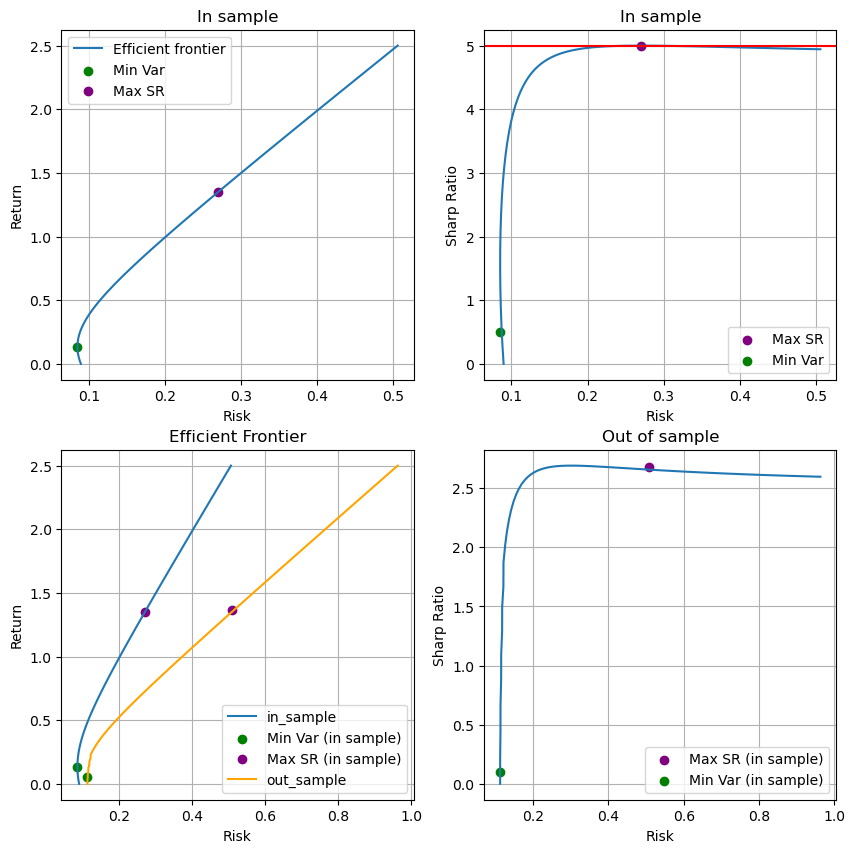

In [46]:
plot_graphs(data_insample,data_outsample)

We can observe that:

- The efficient frontier in the out-of-sample shrinks and shifts to the right
- The portfolio with the highest sharp ratio in the sample does not have the highest sharp ratio out of the sample

## Q-1b : Do the same by using in-sample the eigenvalue clipping and CV

### Clipping

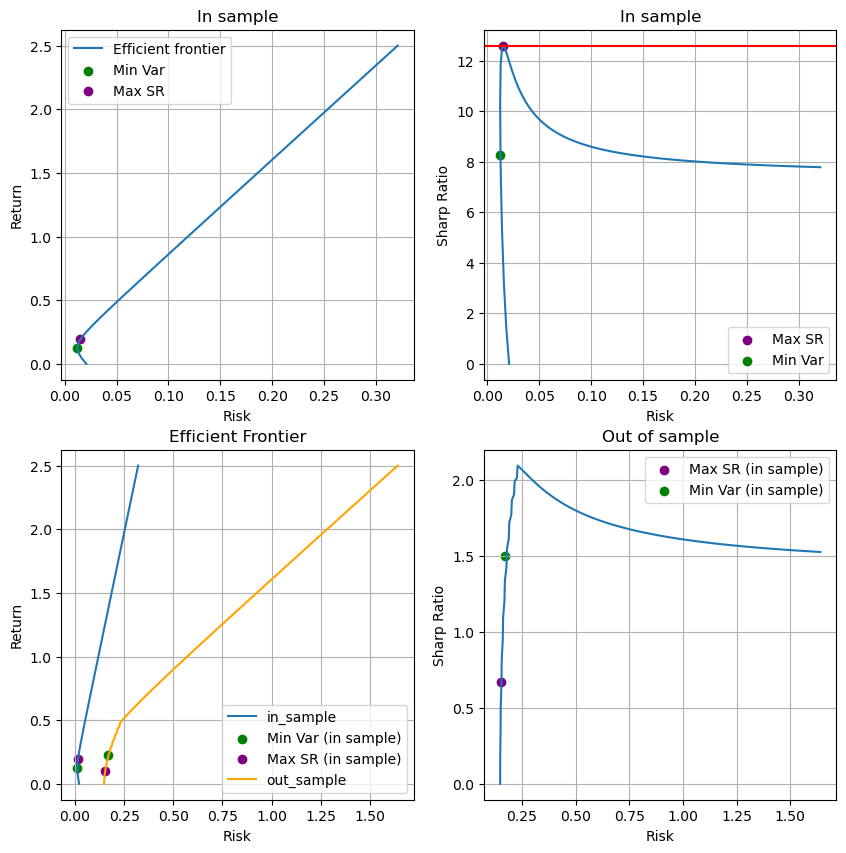

In [19]:
#Clipping
plot_graphs(data_insample,data_outsample,method="clipping")

### cross_validation and isotonic regression

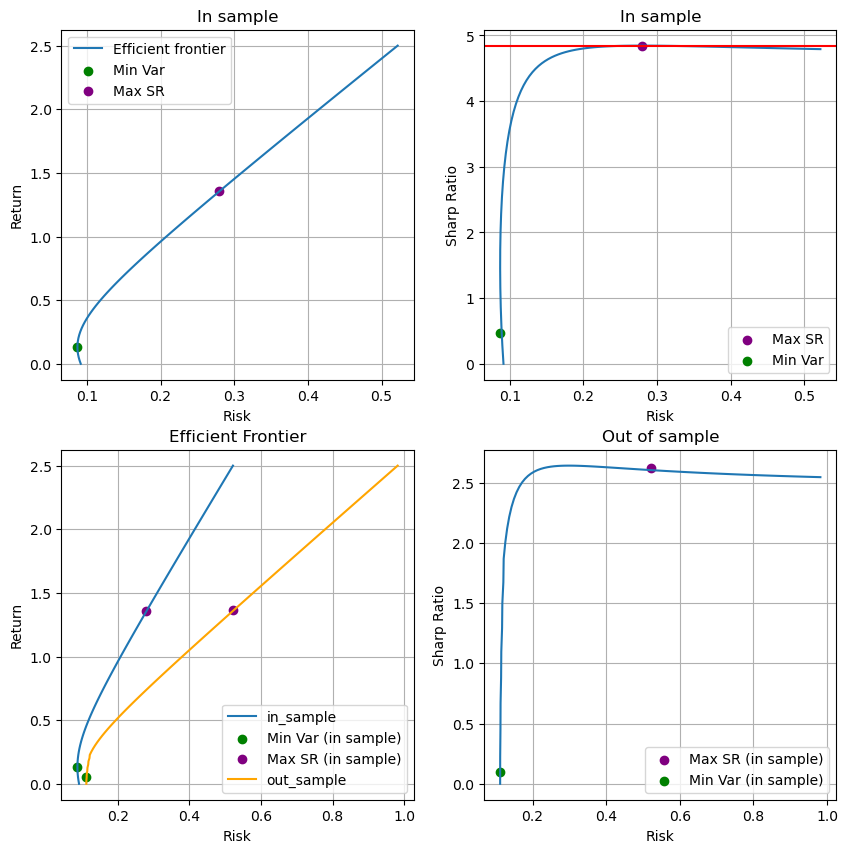

In [20]:
#cross_validation and isotonic regression
plot_graphs(data_insample,data_outsample,method="cv")

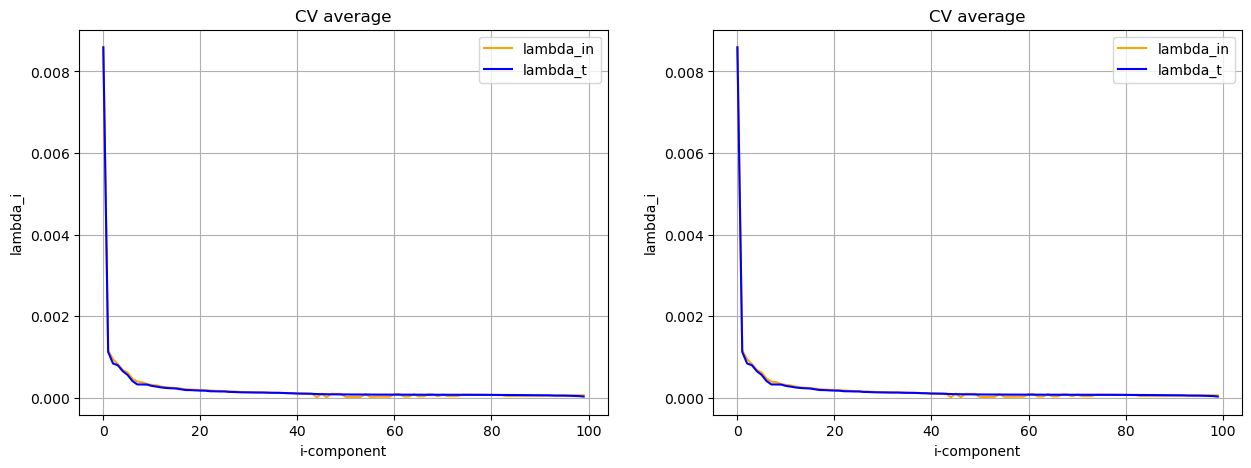

In [22]:
#graphs
nbcross=10
lambda_t = lambda_CV_moy(nbcross, data_insample)
lambda_iso, lambda_in, eigenvectors = lambda_CV_iso(nbcross, data_insample)
lambda_t = np.sort(lambda_t)[::-1]
#lambda_in =np.sort(lambda_in)[::-1]


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(lambda_in,color='orange',label='lambda_in')
plt.plot(lambda_t, color='blue',label='lambda_t')
plt.title("CV average")
plt.xlabel("i-component")
plt.ylabel("lambda_i")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(lambda_in,color='orange',label='lambda_in')
plt.plot(lambda_t, color='blue',label='lambda_t')
plt.title("CV average")
plt.xlabel("i-component")
plt.ylabel("lambda_i")
plt.grid()
plt.legend()



## Q-1c : Comment the differences

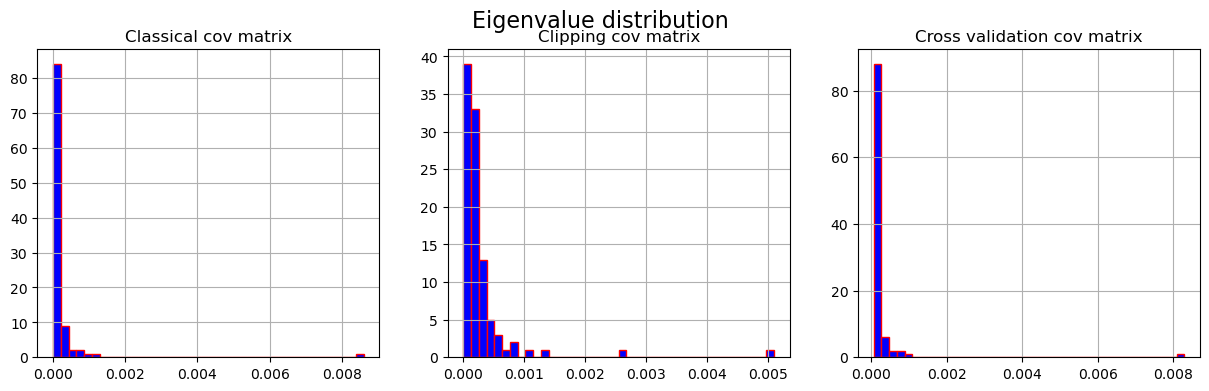

In [51]:
def  eigenvalue_distribution(data):
    
    # classical 
    cov_matrix = np.cov(data.T, bias=True)
    # clipping
    N, t = data.shape[1],data.shape[0]
    corr_matrix_clipping = data.corr()
    cov_matrix_clipping = data.cov()
    var_matrix_clipping = np.diag(np.diag(cov_matrix_clipping))
    cov_matrix_clipping = cov_clipping(N,t,corr_matrix_clipping,var_matrix_clipping)
    # Cross validation 
    cov_matrix_cv = cov_matrix_CV(10,data)
    
    eigenvalues,eigenvectors = np.linalg.eig(cov_matrix)
    eigenvalues_clipping,eigenvectors_clipping = np.linalg.eig(cov_matrix_clipping)
    eigenvalues_cv,eigenvectors_cv = np.linalg.eig(cov_matrix_cv)
    
    plt.figure(figsize=(15,4))
    plt.suptitle("Eigenvalue distribution", fontsize=16)

    plt.subplot(131)
    plt.hist(eigenvalues, bins = 40, color = "blue", edgecolor='red' )
    plt.title("Classical cov matrix")
    plt.grid()
    
    plt.subplot(132)
    plt.hist(eigenvalues_clipping, bins = 40, color = "blue", edgecolor='red' )
    plt.title("Clipping cov matrix")
    plt.grid()
    
    plt.subplot(133)
    plt.hist(eigenvalues_cv, bins = 40, color = "blue", edgecolor='red' )
    plt.title("Cross validation cov matrix")
    plt.grid()
    

eigenvalue_distribution(data_insample)

In [48]:
list_mu_p, vol_in, weights, mu_GMV_in, mu_MSR_in, vol_GMV_in, vol_MSR_in, w_GMV, w_MSR = efficient_frontier(data_insample)
list_mu_p_clipping, vol_in_clipping, weights_clipping, mu_GMV_in_clipping, mu_MSR_in_clipping, vol_GMV_in_clipping, vol_MSR_in_clipping, w_GMV_clipping, w_MSR_clipping = efficient_frontier(data_insample, method="clipping")
list_mu_p_cv, vol_in_cv, weights_cv, mu_GMV_in_cv, mu_MSR_in_cv, vol_GMV_in_cv, vol_MSR_in_cv, w_GMV_cv, w_MSR_cv = efficient_frontier(data_insample, method="cv")
     
vol_out, vol_GMV_out, vol_MSR_out = get_risk(data_outsample, weights, w_GMV, w_MSR)
vol_out_clipping, vol_GMV_out_clipping, vol_MSR_out_clipping = get_risk(data_outsample, weights_clipping, w_GMV_clipping, w_MSR_clipping)
vol_out_cv, vol_GMV_out_cv, vol_MSR_out_cv = get_risk(data_outsample, weights_cv, w_GMV_cv, w_MSR_cv)

In [49]:
vol_out = list(vol_out)
vol_out.sort()
vol_out = np.array(vol_out)                                                  
i_GMV = np.where(vol_out >= vol_GMV_out)[0][0]
mu_GMV_out = list_mu_p[i_GMV]
i_MSR = np.where(vol_out >= vol_MSR_out)[0][0]
mu_MSR_out = list_mu_p[i_MSR]

vol_out_clipping = list(vol_out_clipping)
vol_out_clipping.sort()
vol_out_clipping = np.array(vol_out_clipping)                                                  
i_GMV_clipping = np.where(vol_out_clipping >= vol_GMV_out_clipping)[0][0]
mu_GMV_out_clipping = list_mu_p_clipping[i_GMV_clipping]
i_MSR_clipping = np.where(vol_out_clipping >= vol_MSR_out_clipping)[0][0]
mu_MSR_out_clipping = list_mu_p_clipping[i_MSR_clipping]

vol_out_cv = list(vol_out_cv)
vol_out_cv.sort()
vol_out_cv = np.array(vol_out_cv)                                                  
i_GMV_cv = np.where(vol_out >= vol_GMV_out_cv)[0][0]
mu_GMV_out_cv = list_mu_p_cv[i_GMV_cv]
i_MSR_cv = np.where(vol_out_cv >= vol_MSR_out_cv)[0][0]
mu_MSR_out_cv = list_mu_p_cv[i_MSR_cv]

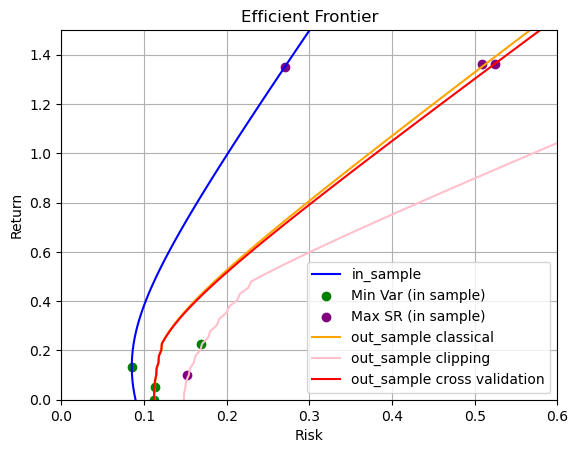

In [50]:
plt.plot(vol_in, list_mu_p, ls="-",label="in_sample", color="blue")
plt.scatter(vol_GMV_in, 252*mu_GMV_in, color='green',label='Min Var (in sample)')
plt.scatter(vol_MSR_in, 252*mu_MSR_in, color='purple',label='Max SR (in sample)')

plt.plot(vol_out, list_mu_p, ls="-",label='out_sample classical', color="orange")
plt.scatter(vol_GMV_out, mu_GMV_out, color='green')
plt.scatter(vol_MSR_out, mu_MSR_out, color='purple')

plt.plot(vol_out_clipping, list_mu_p_clipping, ls="-",label='out_sample clipping', color="pink")
plt.scatter(vol_GMV_out_clipping, mu_GMV_out_clipping, color='green')
plt.scatter(vol_MSR_out_clipping, mu_MSR_out_clipping, color='purple')

plt.plot(vol_out_cv, list_mu_p_cv, ls="-",label='out_sample cross validation', color="red")
plt.scatter(vol_GMV_out_cv, mu_GMV_out_cv, color='green')
plt.scatter(vol_MSR_out_cv, mu_MSR_out_cv, color='purple')

plt.title("Efficient Frontier")
plt.xlabel("Risk")
plt.ylabel("Return")
plt.xlim(0,0.6)
plt.ylim(0,1.5)
plt.grid()
plt.legend()

We observe that the cleaned covariance matrices with the clipping and CV method do not imply better results on the efficient frontiers (the frontiers are shifted to the right: for the same return, the volatility is greater) which is a little surprising
.

# Q2 : Study for different in-sample window size the minVar portfolio performances (in-sample vs out-of-sample) for the filtered and non filtered covariance matrix

In [27]:
def covariance(data, method= "classic",nbCV=100):
    
    """method can take three values: classic, clipping or cv
    nbcv is used when the method is CV"""
    
    # Compute of the mean return and the covariance matrix of the assets
    mu = np.mean(data,axis = 0)
    
    # Estimator of the covariance matrix
    if method == "clipping":
        N, t = data.shape[1],data.shape[0]
        corr_matrix= data.corr()
        cov_matrix = data.cov()
        var_matrix = np.diag(np.diag(cov_matrix))
        cov_matrix = cov_clipping(N,t,corr_matrix,var_matrix)
        
    elif method == "cv":
        
        cov_matrix= cov_matrix_CV(nbCV,data)
    
    
    else:
        cov_matrix = np.cov(data.T, bias=True)

      
    return cov_matrix

In [28]:
def correlation(data, method= "classic",nbCV=100):

    # Estimator of the covariance matrix
    if method == "clipping":
        cov_matrix= covariance(data, method= "clipping",nbCV=nbCV)
        corr_matrix = cov_matrix / (np.sqrt(np.diag(cov_matrix))[:, np.newaxis] * np.sqrt(np.diag(cov_matrix))[np.newaxis, :])

    elif method == "cv":
        cov_matrix = covariance(data, method= "cv",nbCV=nbCV)
        corr_matrix = cov_matrix / (np.sqrt(np.diag(cov_matrix))[:, np.newaxis] * np.sqrt(np.diag(cov_matrix))[np.newaxis, :])


    else:
        corr_matrix = data.corr()

    return corr_matrix

In [29]:
N = 100 #Number of stocks
T2 = 252  #Number of data out of sample

insample_range= np.linspace(252,4000,30,dtype=int)

In [30]:
ret_out_list = []
ret_out_list_CV = []
ret_out_list_clipping = []

vol_out_minvar = []
vol_out_clipping_minvar = []
vol_out_CV_minvar = []

sharpes = []
sharpes_clipping = []
sharpes_cv = []


for insample_size in insample_range :
#insample_size = 1000
    start = time.time()
    T = 252 * 30 - insample_size #beginning date of the insample data

    data_insample = data.iloc[T:T+insample_size, 0:N]
    data_outsample = data.iloc[T+insample_size:T+insample_size+T2, 0:N]

    list_mu_p, vol_in, weights, mu_GMV_in, mu_MSR_in, vol_GMV_in, vol_MSR_in, w_GMV, w_MSR= efficient_frontier(data_insample)
    list_mu_p_clipping, vol_in_clipping, weights_clipping, mu_GMV_in_clipping, mu_MSR_in_clipping, vol_GMV_in_clipping, vol_MSR_in_clipping, w_GMV_clipping, w_MSR_clipping = efficient_frontier(data_insample, method="clipping")
    list_mu_p_cv, vol_in_cv, weights_cv, mu_GMV_in_cv, mu_MSR_in_cv, vol_GMV_in_cv, vol_MSR_in_cv, w_GMV_cv, w_MSR_cv= efficient_frontier(data_insample, method="cv")

    #mu = np.mean(data_outsample,axis = 0)
    mu = data_outsample.sum()

    ret_out_minvar = w_GMV @ mu
    ret_out_clipping_minvar = w_GMV_clipping @ mu
    ret_out_CV_minvar = w_GMV_cv @ mu
    
    
    cov_matrix_out = correlation(data_outsample, method= "classic")
    cov_matrix_clipping_out = correlation(data_outsample, method= "clipping")
    cov_matrix_cv_out = correlation(data_outsample, method= "cv",nbCV=10)

    vol = risk_Portfolio(w_GMV,cov_matrix_out)
    vol_clipping = risk_Portfolio(w_GMV_clipping,cov_matrix_clipping_out)
    vol_cv = risk_Portfolio(w_GMV_cv,cov_matrix_cv_out)

    sharpe = ret_out_minvar / vol
    sharpe_clipping = ret_out_clipping_minvar / vol_clipping
    sharpe_cv = ret_out_CV_minvar / vol_cv
    
    vol_out_minvar.append(vol)
    vol_out_clipping_minvar.append(vol_clipping)
    vol_out_CV_minvar.append(vol_cv)

    ret_out_list.append(ret_out_minvar)
    ret_out_list_clipping.append(ret_out_clipping_minvar)
    ret_out_list_CV.append(ret_out_CV_minvar)

    sharpes.append(sharpe)
    sharpes_clipping.append(sharpe_clipping)
    sharpes_cv.append(sharpe_cv)

    print(f'Computing time : {round(time.time() - start,4)} s')

Computing time : 2.5603 s
Computing time : 2.7357 s
Computing time : 3.0217 s
Computing time : 3.3278 s
Computing time : 3.7014 s
Computing time : 4.1378 s
Computing time : 4.6737 s
Computing time : 5.3339 s
Computing time : 5.8145 s
Computing time : 6.3542 s
Computing time : 7.0384 s
Computing time : 7.9643 s
Computing time : 8.7404 s
Computing time : 9.9692 s
Computing time : 10.8307 s
Computing time : 11.8439 s
Computing time : 12.7449 s
Computing time : 14.0118 s
Computing time : 16.6051 s
Computing time : 17.7001 s
Computing time : 18.0291 s
Computing time : 21.3149 s
Computing time : 21.5313 s
Computing time : 22.2799 s
Computing time : 24.4418 s
Computing time : 24.6357 s
Computing time : 27.1628 s
Computing time : 28.056 s
Computing time : 30.7756 s
Computing time : 30.944 s


## Q-2a : Describe the behaviour of the portfolios with respect the previous cited metrics

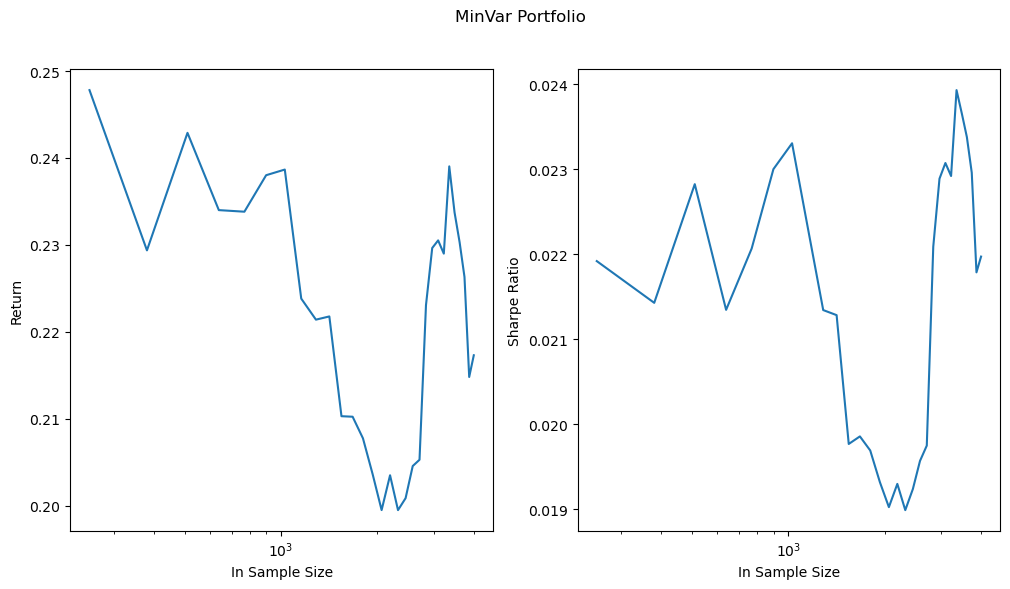

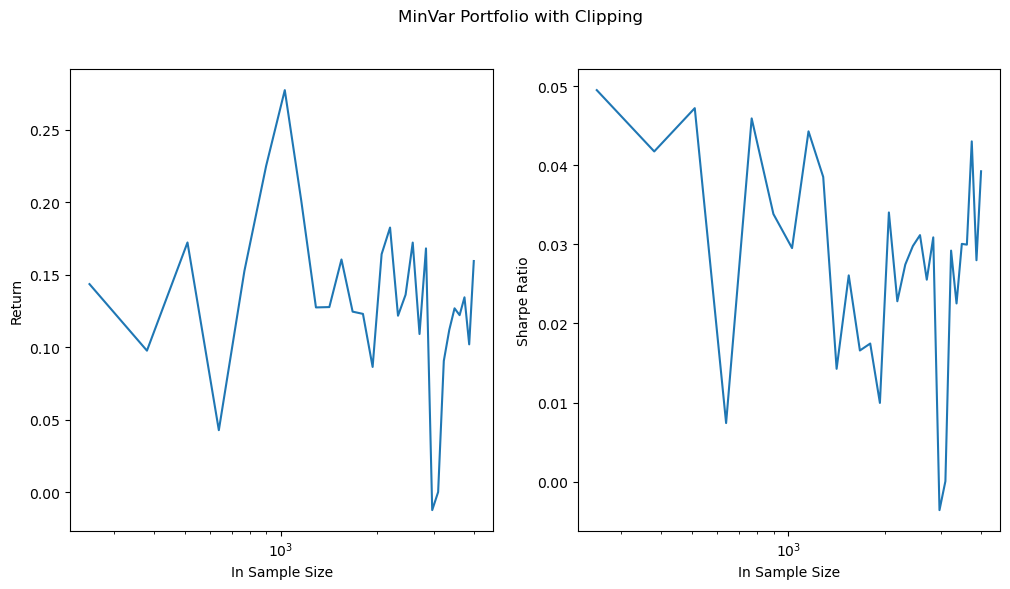

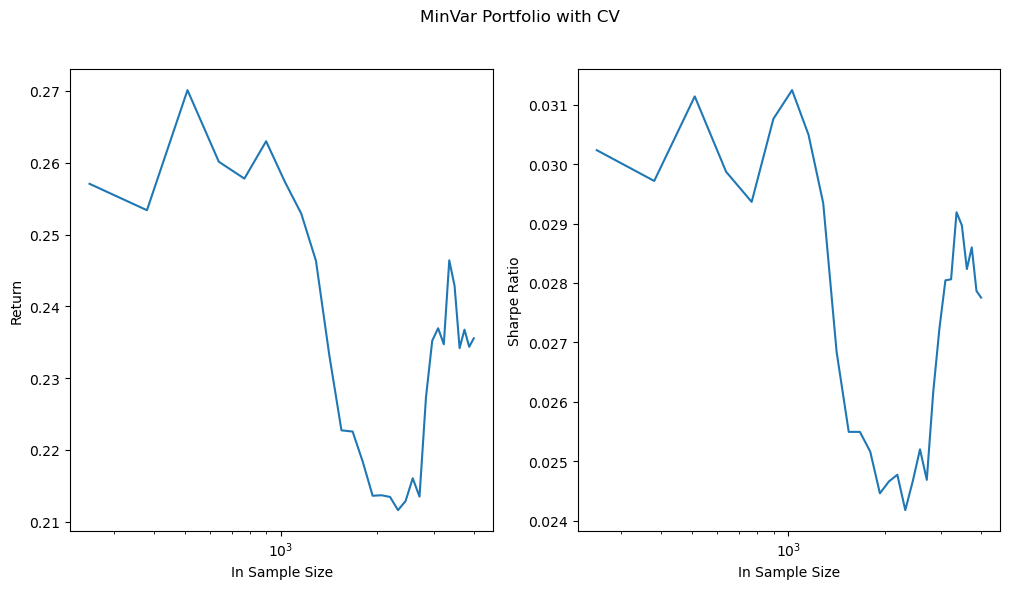

In [31]:
plt.figure(figsize = (12,6))
#################################### Plot 1 & 2 ####################################
plt.suptitle('MinVar Portfolio')

plt.subplot(121)
plt.plot(insample_range, ret_out_list)
plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('Return')

plt.subplot(122)
plt.plot(insample_range, sharpes)
plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('Sharpe Ratio')

########################## Plot 3 & 4 ####################################

plt.figure(figsize = (12,6))
plt.suptitle('MinVar Portfolio with Clipping')

plt.subplot(121)
plt.plot(insample_range, ret_out_list_clipping)
plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('Return')

plt.subplot(122)
plt.plot(insample_range, sharpes_clipping)
plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('Sharpe Ratio')
#################################### Plot 5 & 6 ####################################

plt.figure(figsize = (12,6))
plt.suptitle('MinVar Portfolio with CV')

plt.subplot(121)
plt.plot(insample_range, ret_out_list_CV)
plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('Return')

plt.subplot(122)
plt.plot(insample_range, sharpes_cv)
plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('Sharpe Ratio')

plt.show()

## Q-2b : Comment the results from the point of view of the spectral decomposition

In [32]:
cor_dist = []
cor_clipping_dist = []
cor_cv_dist = []

start = time.time()

#insample_size = 150
for insample_size in insample_range :

    T = 252 * 20 - insample_size #beginning date of the insample data

    data_insample = data.iloc[T:T+insample_size, 0:N]
    data_outsample = data.iloc[T+insample_size:T+insample_size+T2, 0:N]
    
    cor_matrix_in = correlation(data_insample, method= "classic")
    cor_matrix_clipping_in = correlation(data_insample, method= "clipping")
    cor_matrix_cv_in = correlation(data_insample, method= "cv",nbCV=10)
    
    
    cor_matrix_out = correlation(data_outsample, method= "classic")
    cor_matrix_clipping_out = correlation(data_outsample, method= "clipping")
    cor_matrix_cv_out = correlation(data_outsample, method= "cv",nbCV=10)
    


    dist = np.linalg.norm(cor_matrix_in - cor_matrix_out,ord='fro') / N
    dist_clipping = np.linalg.norm(cor_matrix_clipping_in - cor_matrix_clipping_out,ord='fro') / N
    dist_cv = np.linalg.norm(cor_matrix_cv_in - cor_matrix_cv_out,ord='fro') / N

    cor_dist.append(dist)
    cor_clipping_dist.append(dist_clipping)
    cor_cv_dist.append(dist_cv)

print(f'Computing time : {round(time.time() - start,4)} s')

Computing time : 58.9844 s


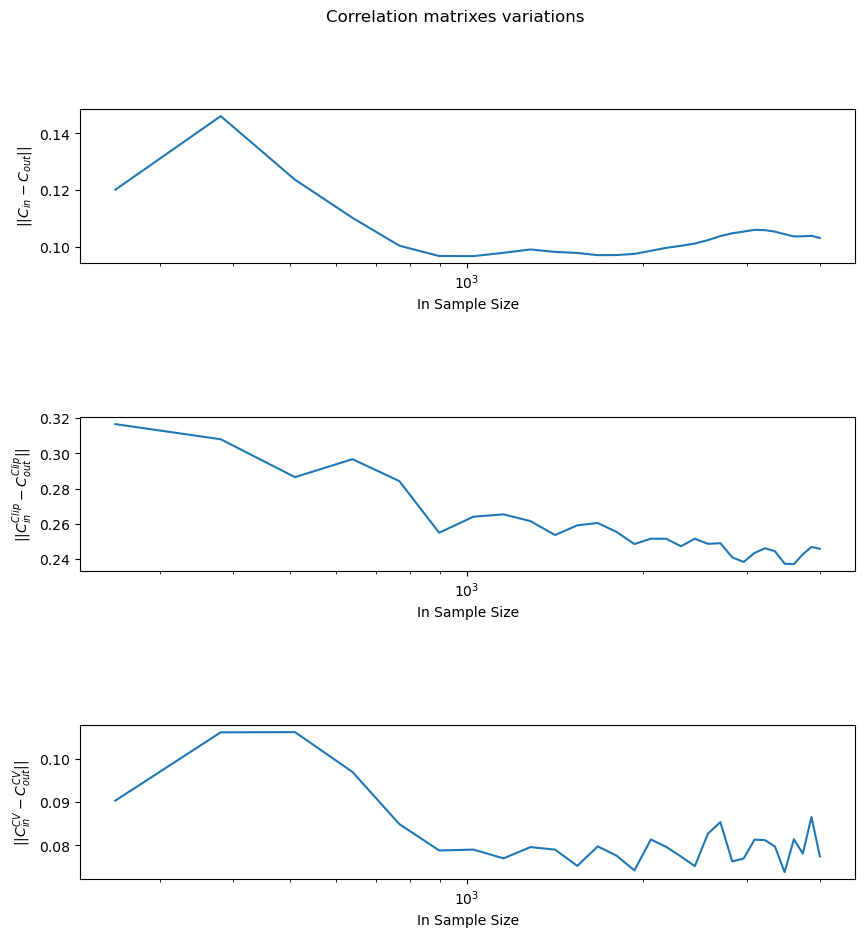

In [33]:
plt.figure(figsize = (10,10))
plt.suptitle('Correlation matrixes variations')
plt.subplots_adjust(wspace=1, hspace=1)

#################################### Plot 1 & 2 ####################################

plt.subplot(311)
plt.plot(insample_range, cor_dist)
plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('$||C_{in} - C_{out}||$')

plt.subplot(312)
plt.plot(insample_range, cor_clipping_dist)
plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('$||C_{in}^{Clip} - C_{out}^{Clip}||$')

plt.subplot(313)
plt.plot(insample_range, cor_cv_dist)
plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('$||C_{in}^{CV} - C_{out}^{CV}||$')

plt.show()

We observe that the Frobenius distances between the insample and correlation matrixes is lower with the CV method and when we increase the sample size.

We expect that the spectral methods will lead to more stable correlation matrixes and thus less variance for the norm of the difference of the insample and outsample matrixes. 

## Q-2c : Compare the eigenvalue distributions of the unfiltered and clipped eigenvalue , CV and the oracle estimators for different in-sample window size and comment the results

In [34]:
from scipy.stats import entropy

In [35]:
kl_divs = []
kl_divs_clipping = []
kl_divs_cv = []

start = time.time()

for insample_size in insample_range :
    
    T = 252 * 20 - insample_size #beginning date of the insample data

    data_insample = data.iloc[T:T+insample_size, 0:N]
    data_outsample = data.iloc[T+insample_size:T+insample_size+T2, 0:N]

    cov_matrix_in = covariance(data_insample, method= "classic",nbCV=100)
    cov_matrix_clipping_in = covariance(data_insample, method= "clipping",nbCV=100)
    cov_matrix_cv_in = covariance(data_insample, method= "cv",nbCV=100)

    cov_matrix_out = covariance(data_outsample, method= "classic",nbCV=100)
    cov_matrix_clipping_out = covariance(data_outsample, method= "clipping",nbCV=100)
    cov_matrix_cv_out = covariance(data_outsample, method= "cv",nbCV=100)

    eigenvalues_in = np.abs(np.linalg.eig(cov_matrix_in)[0])
    eigenvalues_clipping_in = np.abs(np.linalg.eig(cov_matrix_clipping_in)[0])
    eigenvalues_cv_in = np.abs(np.linalg.eig(cov_matrix_cv_in)[0])

    eigenvalues_out = np.abs(np.linalg.eig(cov_matrix_out)[0])
    eigenvalues_clipping_out = np.abs(np.linalg.eig(cov_matrix_clipping_out)[0])
    eigenvalues_cv_out = np.abs(np.linalg.eig(cov_matrix_cv_out)[0])

    dist = entropy(eigenvalues_in,eigenvalues_out) #Kullback-leibler divergence
    dist_clipping = entropy(eigenvalues_clipping_in,eigenvalues_clipping_out)
    dist_cv = entropy(eigenvalues_cv_in,eigenvalues_cv_out)

    kl_divs.append(dist)
    kl_divs_clipping.append(dist_clipping)
    kl_divs_cv.append(dist_cv)

print(f'Computing time : {round(time.time() - start,4)} s')

Computing time : 464.4842 s


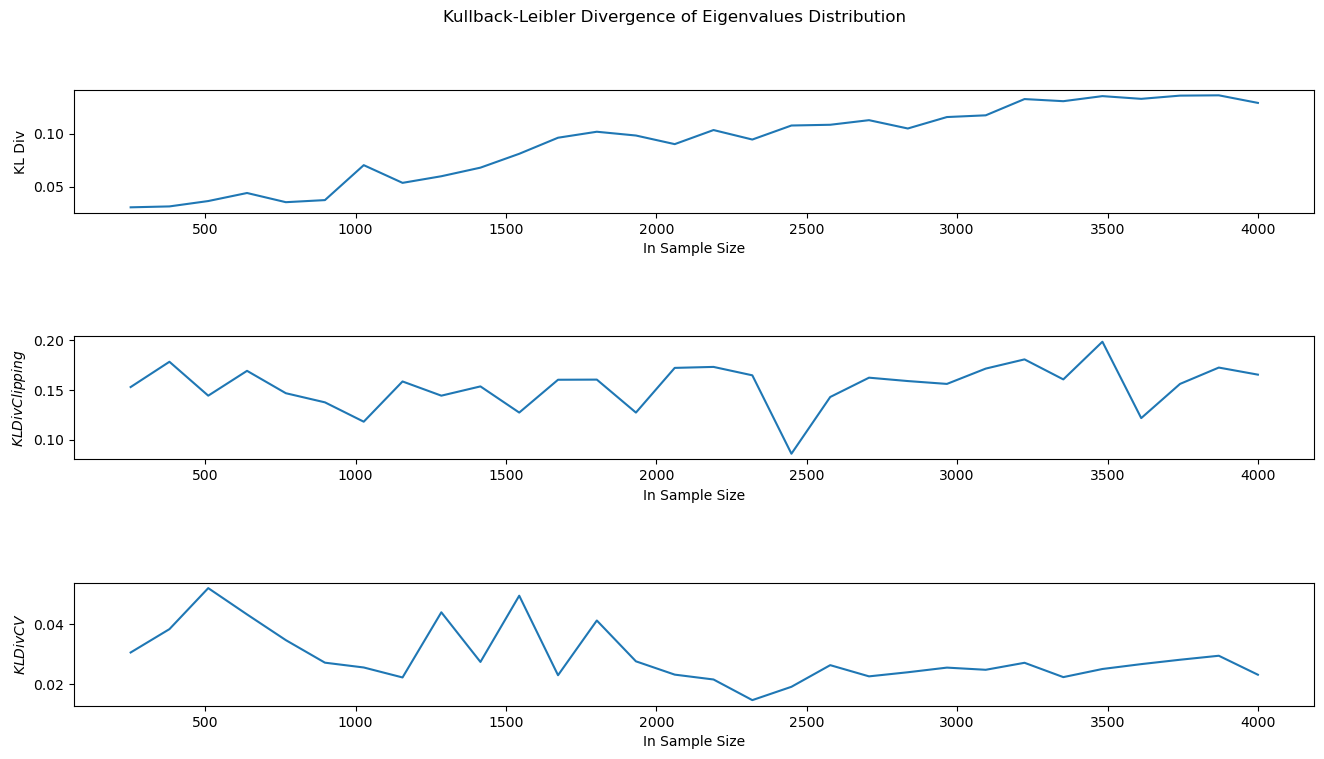

In [36]:
plt.figure(figsize = (16,8))
plt.suptitle('Kullback-Leibler Divergence of Eigenvalues Distribution')
plt.subplots_adjust(wspace=1, hspace=1)

#################################### Plot 1 & 2 ####################################

plt.subplot(311)
plt.plot(insample_range, kl_divs)
#plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('KL Div')

plt.subplot(312)
plt.plot(insample_range, kl_divs_clipping)
#plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('$KL Div Clipping$')

plt.subplot(313)
plt.plot(insample_range, kl_divs_cv)
#plt.xscale('log')
plt.xlabel('In Sample Size')
plt.ylabel('$KL Div CV$')

plt.show()

For the classical covariance matrix, we observe that the larger the in-sample data size, the more the eigenvalues distribution diverges from the one of the out sample data.

However, when we use the clipping method, we do not observe an increasing divergence of the in-sample and out-sample distributions meaning that the covariance matrix is more stable over time.

The best results come from the CV method as we observe a very low Kullback-Leibler divergence between the in-sample and out-sample eigenvalues distributions meaning that those distributions will tend to remain more stable over time.